<a href="https://colab.research.google.com/github/GCioa123/PatternFlow/blob/topic-recognition/G_Chaudhari_VQVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf

from tensorflow.keras.preprocessing.image import load_img

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os

#Loading the data

input_train_dir = 'gdrive/My Drive/keras_png_slices_data/keras_png_slices_data/keras_png_slices_train/' #this you have give your seg_train folder path
target_train_dir = 'gdrive/My Drive/keras_png_slices_data/keras_png_slices_data/keras_png_slices_seg_train/' #seg_val folder path
input_val_dir = 'gdrive/My Drive/keras_png_slices_data/keras_png_slices_data/keras_png_slices_validate/' #this you have give your seg_train folder path
target_val_dir = 'gdrive/My Drive/keras_png_slices_data/keras_png_slices_data/keras_png_slices_seg_validate/' #seg_val folder path


In [4]:
# Extract data to train and test data sets
img_size = (256, 256)
num_classes = 4
batch_size = 1

input_img_paths = sorted(
    [
        os.path.join(input_train_dir, fname)
        for fname in os.listdir(input_train_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_train_dir, fname)
        for fname in os.listdir(target_train_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

val_input_img_paths = sorted(
    [
        os.path.join(input_val_dir, fname)
        for fname in os.listdir(input_val_dir)
        if fname.endswith(".png")
    ]
)
val_target_img_paths = sorted(
    [
        os.path.join(target_val_dir, fname)
        for fname in os.listdir(target_val_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))


Number of samples: 9664


In [5]:
#vectoriser

class VectorQuantizer(layers.Layer):
  """
      This is a class to implement a layer as a vector-quantizer.

      Attributes: 
      Layer: This is a layer of the VQ-VAE model which is a Tensor object.
      
  """
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
      """
        The constructor for VectorQuantizer class.
  
        Parameters:
           num_embeddings (int): the number of embeddings for the vector quantizer.
           embedding_dim (int) : dimension of embedding.
           beta (float) : weights for each layer in vector quantizer.
      """

        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = (
            beta  # This parameter is best kept between [0.25, 2] as per the paper.
        )

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
      """
      A function to compute the loss of the layer.
  
        Parameters:
           x (Tensor object): the inputs to the vector quantizer layer.
        Returns:
        quantized (Tensor object): output from vector quantizer layer 

      """

        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. 
        commitment_loss = self.beta * tf.reduce_mean(
            (tf.stop_gradient(quantized) - x) ** 2
        )
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
      """
      A function which calculates L2-normalized distance between the inputs and the embeddings.

      Parameters:
        flattened_inputs (Tensor object): takes in flattened input from the layers.
        
      Returns:
        encoding_indices (int #change) : returns the index containing the minimum distance.

      """
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [6]:
#encoder 
def get_encoder(latent_dim=32):
  """
  A function which implements the encoder of the VQ-VAE model.

  Parameters:
    latent_dim (int): accepts the latent dimension.

  Returns:
    encoder (keras.Model) : the encoder of the VQ-VAE model

  """
    encoder_inputs = keras.Input(shape=(80, 80, 3))
    x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 3, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


In [7]:
#decoder
def get_decoder(latent_dim=32):
  """
  A function which implements the decoder of the VQ-VAE model.

  Parameters:
    latent_dim (int): accepts the latent dimension.

  Returns:
    decoder (keras.Model) : the decoder of the VQ-VAE model

  """
  
    latent_inputs = keras.Input(shape=get_encoder().output.shape[1:])
    x = layers.Conv2DTranspose(16,3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(3, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [8]:
#Stand-alone VQ-VAE
def get_vqvae(latent_dim=32, num_embeddings=64):
  """
  A function which implements the VQ-VAE model.

  Parameters:
    latent_dim (int): accepts the latent dimension.
    num_embeddings (int): the number of embeddings in the vector quantizer.

  Returns:
    vq_vae (keras.Model) : the VQ-VAE model

  """
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(80, 80, 3))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()


Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 encoder (Functional)        (None, 20, 20, 32)        7408      
                                                                 
 vector_quantizer (VectorQua  (None, 20, 20, 32)       2048      
 ntizer)                                                         
                                                                 
 decoder (Functional)        (None, 80, 80, 3)         7379      
                                                                 
Total params: 16,835
Trainable params: 16,835
Non-trainable params: 0
_________________________________________________________________


In [9]:
#VQ-VAE Trainer
class VQVAETrainer(keras.models.Model):
  """
  A class which trains the VQ-VAE model.

  Attributes:
  vq_vae: builds the VQ-VAE model for training data.

  """
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
      """
        The constructor for VQVAETrainer class.
  
        Parameters:
           train_variance (float): the variance of the input data.
           latern_dim (int) : number of latent dimensions.
           num_embeddings (int) : number of embeddings in vector quantizer of VQVAE model.
      """
      
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
      """
        A function to define metrics for model performance.

        Returns:
        total_loss_tracker (float) : returns the total loss of the current state of the model
        reconstruction_loss (float) : returns the reconstruction loss of the current state of the model
        vq_loss_tracker (float) : returns the vq_loss_tracker of the current state of the model
      """
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
      """
        A function to train the input data step by step and calculate the metrics accordingly.
        
        Parameters:
        x (array #change) : takes in the input training data 

        Returns:
        total_loss_tracker (float) : returns the total loss of the current state of the model
        reconstruction_loss (float) : returns the reconstruction loss of the current state of the model
        vq_loss_tracker (float) : returns the vq_loss_tracker of the current state of the model

      """

      #change 
      
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            # og code delete - reconstructions = self.vqvae(x)
            # x = tf.expand_dims(x, axis=1)

            tmp_result = self.vqvae(x) #change tmp

            #Calculate image difference using SSIM
  
            # print(x.shape)
            # print(tf.expand_dims(x,-1).shape)
            # print(tmp_result.shape)
            #change
            # print("x",x)
            # print("o/p",tmp_result)
            

            img_diff = 1-(tf.image.ssim(x,tmp_result,1.0))
            
            # print("img",img_diff)


            # Calculate the losses. Mean squared error, change
            reconstruction_loss = (
                tf.reduce_mean((x - tmp_result) ** 2) / self.train_variance
            )
            total_loss = ( img_diff + sum(self.vqvae.losses))

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))
        #self.optimizer = tf.keras.optimizers.Adam(0.001).minimize((-1*img_diff))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss(SSIM)": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }


In [10]:

class oasis_data(keras.utils.Sequence):
    """
    A class which iterates over the OASIS data and extracts the image information.
    
    """

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
      """
        The constructor for extracting the image information.
  
        Parameters:
           batch_size (int): the batch size of the image.
           img_size (int) : the image size of the images.
           input_img_paths (list) : A list of file paths to the training dataset
           target_img_paths (list) : A list of file paths to the testing dataset.
      """
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
      """
      A function which returns the length of the object.

      Returns:
        Returns (int) length of the list object.

      """
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
      """
      A function which extracts the image information for the specified index.

      Parameters:
        idx (int) : an index of that describes which image is extracted from the list.

      Returns:
        x (Numpy array) : returns image information (pixel) of specified index (idx).

      """
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = np.array(load_img(path, target_size=self.img_size))
            x[j] = img/255
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = np.array(load_img(path, target_size=self.img_size, color_mode="grayscale"))
            # y[j] = np.expand_dims(img, 2)
            # # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            # y[j] -= 1
            one_hot = img == [0, 85, 170, 255]
            y[j] = one_hot
            
        # return x, y
        return x


In [11]:
#Load train and test data from OASIS dataset.

import random

train_input_img_paths = input_img_paths[:]
train_target_img_paths = target_img_paths[:]
val_input_img_paths = val_input_img_paths[:]
val_target_img_paths = val_target_img_paths[:]

# Loading training data 
train_gen = oasis_data(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
# Loading testing data
val_gen =  oasis_data(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [12]:
print(train_gen.__len__(), val_gen.__len__())


9664 1120


In [69]:
# Extracting training and testing data from OASIS Dataset.

# X_train,y_train = train_gen.__getitem__(9664)
# X_test, y_test = val_gen.__getitem__(1) .reshape(256,256,3)
X_train = np.array([tf.reshape(tf.image.resize(train_gen.__getitem__(i),[80,80]),[80,80,3]) for i in range(train_gen.__len__())])
#

#X_train = np.array([tf.reshape(tf.image.resize(train_gen.__getitem__(i),[28,28]),[28,28,3]) for i in range(train_gen.__len__())])
#X_test = np.array([tf.reshape(tf.image.resize(val_gen.__getitem__(i),[28,28]),[28,28,3]) for i in range(val_gen.__len__())])

X_test = np.array([tf.reshape(tf.image.resize(val_gen.__getitem__(i),[80,80]),[80,80,3]) for i in range(25)])


# X_train = np.array([tf.image.resize(train_gen.__getitem__(i),[28,28]) for i in range(5)])


# dimension reduction to make images the same shape
# X_train = tf.expand_dims(X_train, axis=1)
# X_test = tf.expand_dims(X_test, axis=0) 

x_train_scaled = (X_train / 80.0) - 0.5
x_test_scaled = (X_test / 80.0) - 0.5

data_variance = np.var(X_train / 255.0)

print(data_variance)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


5.3327756e-07


In [70]:
#tf.image.ssim(X_train[0], X_train[1],1)
print(X_train[0].shape)

(80, 80, 3)


In [71]:
# temp = X_train[0].reshape(256,256,3)
len(X_train)

9664

In [73]:
#train VQ VAE model
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=32, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(X_train, epochs=25)


Epoch 1/25
302/302 [==============================] - 423s 1s/step - loss(SSIM): 4.0296 - reconstruction_loss: 32615.1426 - vqvae_loss: 3.4865
Epoch 2/25
302/302 [==============================] - 422s 1s/step - loss(SSIM): 2.8652 - reconstruction_loss: 11953.4658 - vqvae_loss: 2.6008
Epoch 3/25
302/302 [==============================] - 422s 1s/step - loss(SSIM): 1.5297 - reconstruction_loss: 10250.9961 - vqvae_loss: 1.3008
Epoch 4/25
302/302 [==============================] - 421s 1s/step - loss(SSIM): 0.9159 - reconstruction_loss: 9056.9346 - vqvae_loss: 0.7054
Epoch 5/25
302/302 [==============================] - 422s 1s/step - loss(SSIM): 0.6958 - reconstruction_loss: 8035.6670 - vqvae_loss: 0.5042
Epoch 6/25
302/302 [==============================] - 421s 1s/step - loss(SSIM): 0.6220 - reconstruction_loss: 7379.6724 - vqvae_loss: 0.4444
Epoch 7/25
302/302 [==============================] - 420s 1s/step - loss(SSIM): 0.5618 - reconstruction_loss: 6851.9521 - vqvae_loss: 0.3951
Epo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


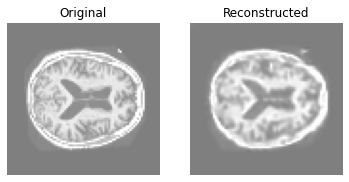

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


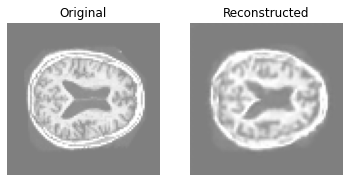

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


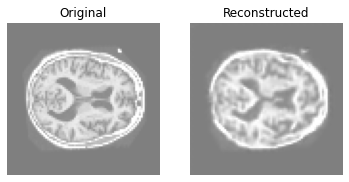

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


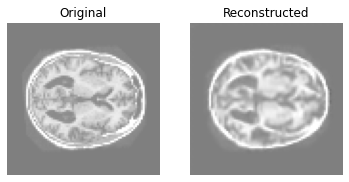

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


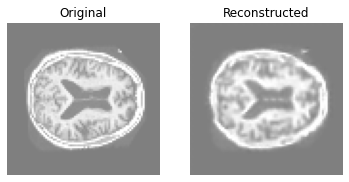

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


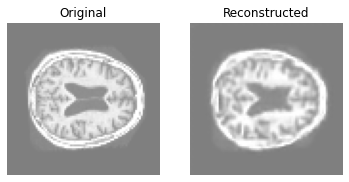

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


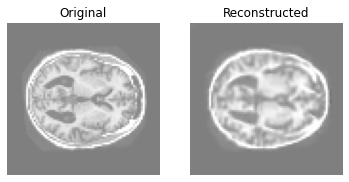

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


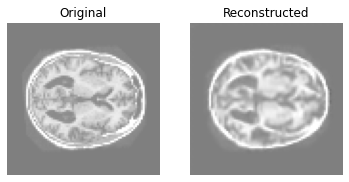

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


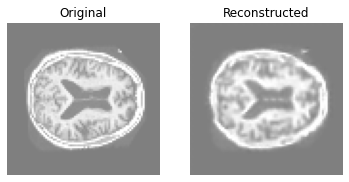

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


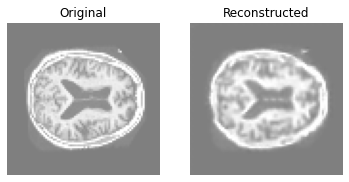

In [74]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(X_test), 10)
test_images = X_test[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)



In [75]:

trained_vqvae_model = VQVAETrainer(data_variance, latent_dim=32, num_embeddings=128)
trained_vqvae_model.compile(optimizer=keras.optimizers.Adam())
trained_vqvae_model.fit(x_test_scaled, epochs=10)


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss(SSIM): 1.0083 - reconstruction_loss: 467930.5000 - vqvae_loss: 0.0039
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss(SSIM): 0.9981 - reconstruction_loss: 463214.6250 - vqvae_loss: 0.0036
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss(SSIM): 0.9836 - reconstruction_loss: 456902.2812 - vqvae_loss: 0.0031
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss(SSIM): 0.9722 - reconstruction_loss: 451679.4375 - vqvae_loss: 0.0031
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss(SSIM): 0.9608 - reconstruction_loss: 446366.6875 - vqvae_loss: 0.0033
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss(SSIM): 0.9489 - reconstruction_loss: 440761.3750 - vqvae_loss: 0.0036
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss(SSIM): 0.9367 - reconstruction_loss: 434855.8438 - vqvae_loss: 0.0043
Epoch 8/10
1/1 [==================

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


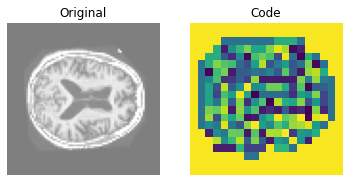

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


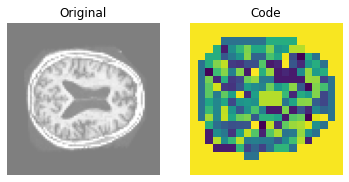

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


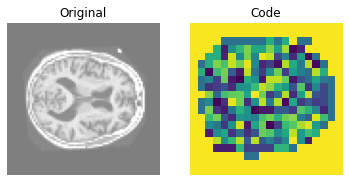

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


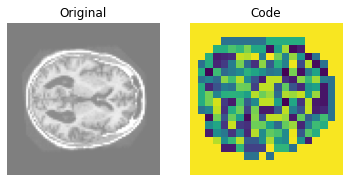

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


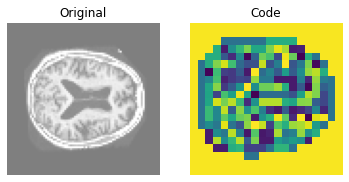

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


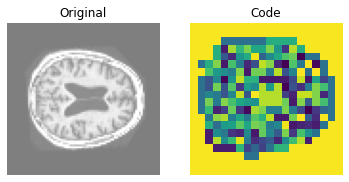

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


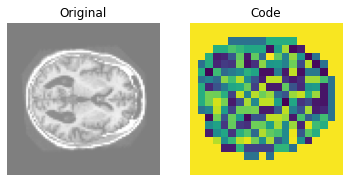

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


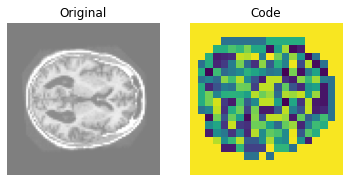

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


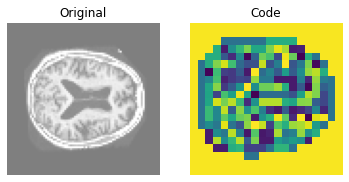

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


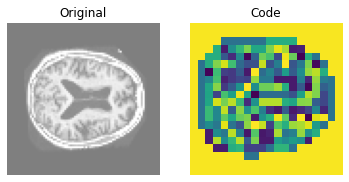

In [76]:
#Visualising the discrete codes 

encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()